# Final Notebook for King County Housing Prices Report 

The purpose of this notebook is to layout the steps that our group took for the following parts of this project:
 - Data acquisition
 - Data cleaning/exploration
 - Modeling
 - Analysis
 
Included are all of the necessary code cells needed to recreate our project.

## Data Acquisition

Our data came from the King County website [here](https://info.kingcounty.gov/assessor/DataDownload/default.aspx). From this site we downloaded three .csv files that would make up the entirety of our dataset for the project. These were 
 1. Real Property Sales
 2. Residential Building
 3. Parcel

With these three datasets, along with the provided Lookup table, we were able to get a lot of information on each property sale. The datasets were far too large to save and pass around intially; to make them easier to deal with, we imported them, joined them using their common Major and Minor PIN columns, and then filtered only those sales from 2019. We exported them into the data directory as 'master.csv'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power
%matplotlib inline

In [2]:
import os
print(os.getcwd())

C:\Users\jaker\Documents\Flatiron\project\mod2-project-group-3\notebooks


#### First we will import our unified data file

In [3]:
# make sure the dtype of 'id' is object to preserve its formatting
raw = pd.read_csv('../data/master.csv', low_memory=False, dtype={'id': object})

#### Now we want to filter out items with a SalePrice of 0 or lower

In [4]:
df = raw[raw.SalePrice > 0]

#### Now we select the sales with the proper PropertyType codes
The following code is of interest to us:
 - 11: Household, single family units

These are not because they don't help us answer our questions about buying a house

 - 12: Multiple family residence (Residential, 2-4 units)
 - 13: Multiple family residence (Residential, 5+ units)
 - 14: Residential condominiums

In [5]:
proptypes = [11]
df = df[df.PropertyType.isin(proptypes)]

## Modeling

Next we will fit our first model that tries to indicate the sale prices of homes in 2019. Our first instinct was to make the total square footage of living space the dependant variable. We used StatsModels' ols function to generate our model.

In [6]:
fsm_df = df[["SalePrice", "SqFtTotLiving"]].copy()
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving'
fsm = ols(formula=formula, data=fsm_df).fit()

Here is an image of the best fit line on top of the data

![](../src/regression.png)


Now we need to see the details

In [7]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.187e+04
Date:                Sun, 21 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:09:21   Log-Likelihood:            -2.7203e+05
No. Observations:               18807   AIC:                         5.441e+05
Df Residuals:                   18805   BIC:                         5.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.591e+04   8189.002     -1.942      0.052    -3.2e+04     144.477
SqFtTotLiving   378.6638      3.476    108.935      0.000     371.850     385.477
==============================================================================
Omnibus:                    24151.837   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12404873.130
Skew:                           6.729   Prob(JB):                         0.00
Kurtosis:                     128.096   Cond. No.                     5.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### First model
 - Our first model starts with an Rsquared value of .387
 - We have a coefficient of 378 for SqFtTotLiving
 - This coefficient can be interpreted as saying: for each additional square foot of living space, you can expect an increase of $387 to the sale price

Let's check some of our linearity assumptions.

 > First we have homoscedasticity

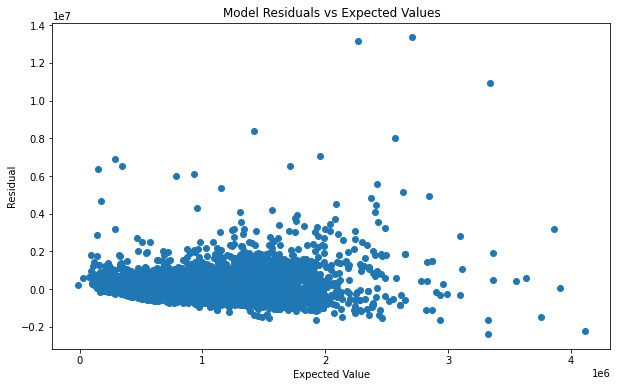

In [8]:
fsm_resids = fsm.resid
y_hat = fsm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, fsm_resids);
ax.set_title('Model Residuals vs Expected Values')
ax.set_xlabel('Expected Value')
ax.set_ylabel('Residual');

It seems like our model is fairly heteroscedastic: it works better for lower expected values, but it becomes less reliable in the higher sale prices.

Let's try adding in a bathroom count. We will count all types of bathrooms as 1 bathroom (rather than weighting them by type), this seems like how we expect bathrooms to affect price.

In [9]:
df['bathrooms'] = (df.BathHalfCount +
                   df.Bath3qtrCount +
                   df.BathFullCount)

#### Now we fit a new model with total bathrooms and total sqft as our independant variables

In [10]:
ssm_df = df[["SalePrice", "SqFtTotLiving", "bathrooms"]].copy()
ssm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving + bathrooms'
ssm = ols(formula=formula, data=ssm_df).fit()
ssm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     5955.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:09:21   Log-Likelihood:            -2.7201e+05
No. Observations:               18807   AIC:                         5.440e+05
Df Residuals:                   18804   BIC:                         5.441e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -3.97e+04   9399.471     -4.224      0.000   -5.81e+04   -2.13e+04
SqFtTotLiving   357.1903      5.429     65.788      0.000     346.548     367.832
bathrooms       2.71e+04   5266.766      5.146      0.000    1.68e+04    3.74e+04
==============================================================================
Omnibus:                    24183.808   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12469033.634
Skew:                           6.745   Prob(JB):                         0.00
Kurtosis:                     128.419   Cond. No.                     6.88e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Second model
 - Our second model has an Rsquared value of .388
 - We have coefficients of 357 for SqFtTotLiving and 27,100 for bathrooms
 - These coefficients can be interpreted as saying: for each additional square foot of living space, you can expect an increase of $357 to the sale price, and for each additional bathroom the sale price would increase 27,100 dollars

Let's check some of our linearity assumptions.

 > Let's see how correlated bathrooms and square footage are

In [11]:
ssm_df.corr()

,SalePrice,SqFtTotLiving,bathrooms
SalePrice,1.000000,0.622011,0.496833
SqFtTotLiving,0.622011,1.000000,0.768551
bathrooms,0.496833,0.768551,1.000000


It appears that the number of bathrooms a home has is highly
correlated with the total square footage, which is not surprising. For this reason, we should not use both features as indicators in our model. We will stick with square footage.

> Our group had the idea to explore location's effect on sale prices, so we generated a map to visualize the average home prices in different ZIP codes. The code for generating this map with its annotations can be found in the maptime notebook [here](exploratory/jp-4-maptime.ipynb). The result of this code is displayed below:

![](../src/map.png)

Seeing this, it seemed clear that there are at least two distinct regions when it comes to home sale prices in the county, so we divided the county in two:

 - The three darkest ZIP codes (98039, 98004, 98040) we put into one group that we called the 'money zone'
 - The rest of the ZIP codes were not in the money zone
 
We'll add this as a categorical column to our data

In [12]:
money_zone = ['98039', '98004', '98040']
df['money_zone'] = df.ZipCode.isin(money_zone)

Now let's fit a model including this

In [13]:
tsm_df = df[["SalePrice", "SqFtTotLiving", "money_zone"]].copy()
tsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving + money_zone'
tsm = ols(formula=formula, data=tsm_df).fit()
tsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     8264.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:09:21   Log-Likelihood:            -2.7069e+05
No. Observations:               18807   AIC:                         5.414e+05
Df Residuals:                   18804   BIC:                         5.414e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.928e+04   7676.583      3.814      0.000    1.42e+04    4.43e+04
money_zone[T.True]  1.076e+06   2.01e+04     53.459      0.000    1.04e+06    1.12e+06
SqFtTotLiving        344.5572      3.301    104.381      0.000     338.087     351.027
==============================================================================
Omnibus:                    23724.011   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12006715.882
Skew:                           6.498   Prob(JB):                         0.00
Kurtosis:                     126.098   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Third model
 - Our third model has an Rsquared value of .468
 - We have coefficients of 344 for SqFtTotLiving, 1,076,000 for money zone
 - These coefficients can be interpreted as saying: for each additional square foot of living space, you can expect an increase of $344 to the sale price, and all things else the same, being inside this three ZIP code zone will increase the price by about 1 million dollars
 - The intercept coefficient of 29,280 refers to the expected price for a zero sqft house outside of the 'money zone'

Let's check some of our linearity assumptions.

 > Let's see how correlated square footage and the 'money zone' are

In [14]:
tsm_df.corr()

,SalePrice,SqFtTotLiving,money_zone
SalePrice,1.000000,0.622011,0.399264
SqFtTotLiving,0.622011,1.000000,0.193275
money_zone,0.399264,0.193275,1.000000


Now let's check homoscedasticity

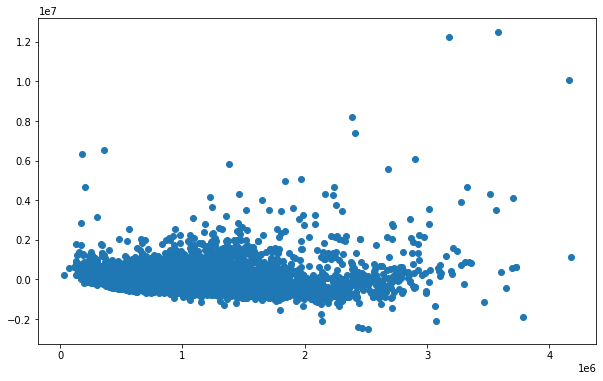

In [25]:
resids = tsm.resid
y_hat = tsm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, resids);

Looks a little better than before, a little tighter around the multiple million dollar homes.

Let's check the normality

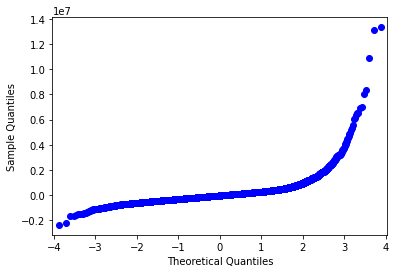

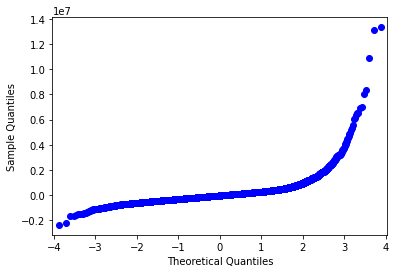

In [26]:
sm.qqplot(fsm_resids)

With this plot, and the JB score above, it seems that our residuals are still not quite normally distributed

An idea we had for improving the model was to make a new measure for how far away each house was from downtown Seattle, and then using that distance as an independant variable.

## Analysis

### The first claim we are going to investigate is whether duplexes have a lower price per square foot than single family homes

Our hypothesis:

 - Null: The cost per square foot is higher or equal in duplexes than in single-family homes
 - Alternative: The cost per square foot is lower in duplexes than in single-family homes
 
We'll seperate the necessary data below 

In [15]:
#get relevant columns
tester = df[["SalePrice", "SqFtTotLiving", "PresentUse"]].copy()

#PresentUse 2 and 3 refer to single family homes and duplexes respectively
tester = tester[(tester.PresentUse == 2) | (tester.PresentUse == 3)].copy()
tester.dropna(inplace=True)

# Make a new column for price per sqft
tester['ppsqft'] = tester.SalePrice / tester.SqFtTotLiving

# Seperate prices for duplexes and single family homes
duplex_prices = tester[tester.PresentUse == 3].ppsqft 
single_prices = tester[tester.PresentUse == 2].ppsqft

Now we will do a one-tailed Welch's t-test

In [16]:
stats.ttest_ind(single_prices, duplex_prices)

Ttest_indResult(statistic=-1.0929869900053728, pvalue=0.27441486970974877)

With this statistic and p-value we should **not reject the null hypothesis** that the cost per square foot is higher or equal in duplexes than in single-family homes

Let's get the power and effect size for this test

Here's the function we will use to compute the effect size

In [17]:
def Cohen_d(group1, group2):
    """
    Computes Cohen's d.
    """
    diff = group1.mean() - group2.mean()
    n1 = len(group1)
    n2 = len(group2)
    var1 = group1.var(ddof=1)  #ddof = delta degrees of freedom
    var2 = group2.var(ddof=1)
    # Calculate the pooled variance
    pooled_var = ((n1-1) * var1 + (n2-1) * var2) / (n1 + n2 - 2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d

Now let's see our power and effect size

In [18]:
d = Cohen_d(single_prices, duplex_prices)
power = tt_ind_solve_power(effect_size=d, nobs1=len(duplex_prices),
                           alpha=.05, ratio=len(single_prices)/len(duplex_prices),
                           alternative='smaller')
print(f'Power: {power} \nEffect Size: {d}')

Power: 0.2905050904230857 
Effect Size: -0.10502352517242299


### Our second claim to investigate is whether having a porch increases sale price

Our hypothesis:

 - Null: Homes with a porch have a sale price that is less than or equal to those without a porch
 - Alternative: Homes with a porch have a sale price that is higher than those without a porch
 
We'll seperate the necessary data below 

In [19]:
# Seperate houses that have porch/deck space from those that do not
df['OutdoorSpace']= df['SqFtOpenPorch']+df['SqFtEnclosedPorch']+df['SqFtDeck']
no_out = df[df.OutdoorSpace == 0]
yes_out = df[df.OutdoorSpace > 0]

# Get the sale prices of both categories
control = no_out.SalePrice.values
exper = yes_out.SalePrice.values

# Conduct our 1-tailed Welch's t-test
stats.ttest_ind(exper, control, equal_var=False)

Ttest_indResult(statistic=29.00193232994214, pvalue=1.6134962278852268e-178)

With this statistic and p-value, and at a power of .95, we can safely **reject the null hypothesis**

Let's see our power and effect size

In [20]:
d = Cohen_d(exper, control)
power = tt_ind_solve_power(effect_size=d, nobs1=len(control),
                           alpha=.05, ratio=len(exper)/len(control),
                           alternative='larger')
print(f'Power: {power} \nEffect Size: {d}')

Power: 1.0 
Effect Size: 0.38647356691448825


&nbsp;  
**Our third claim to investigate is whether having a beachfront or lakefront increases home sale price**

 - Null: Homes with beachfront or lakefront access have a sale price that is less than or equal to those without
 - Alternative: Homes with beachfront or lakefront access have a sale price that is higher than those without
 
We'll seperate the necessary data below 

In [21]:
# Seperate the sale prices of homes with a waterfront location and those without
control = df[df.WfntLocation == 0].SalePrice.values
expr = df[df.WfntLocation > 0].SalePrice.values

First let's see how are averages compare

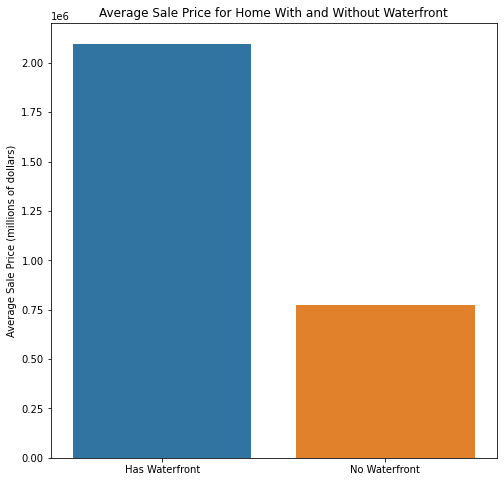

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=['Has Waterfront', 'No Waterfront'],
            y=[expr.mean(), control.mean()], ax=ax);
ax.set_title('Average Sale Price for Home With and Without Waterfront')
ax.set_ylabel('Average Sale Price (millions of dollars)');

Unsurprisingly it seems that having waterfront access increases the value of a home substantially, but let's run a test to see if this is the case. 

We will use a 1-tailed Welch's t-test

In [23]:
stats.ttest_ind(exper, control, equal_var=False)

Ttest_indResult(statistic=10.351864771596853, pvalue=4.503430180948232e-25)

With this p-value, t-stat, and a power of .95, we can safely **reject our null hypothesis**

Let's get our power and effect size

In [24]:
d = Cohen_d(exper, control)
power = tt_ind_solve_power(effect_size=d, nobs1=len(control),
                           alpha=.05, ratio=len(exper)/len(control),
                           alternative='larger')
print(f'Power: {power} \nEffect Size: {d}')

Power: 1.0 
Effect Size: 0.11410044220984619
